## Applied Machine Learning | Final Project: Abnormal Behaviour Classification Using a Custom Convolutional Neural Network
### Kabi Sabina, Zhapparova Amina | BDA-2304

This project focuses on building a multi-class image classification model for detecting abnormal human behaviours using a fully custom Convolutional Neural Network (CNN). The model is trained from scratch without using any pretrained architectures, which aligns with the project requirement to demonstrate a deep understanding of convolutional model design.

### Dataset
The dataset consists of seven abnormal behaviour classes:
- cheating  
- falling  
- fight  
- fleeing  
- kicking  
- punching  
- pushing  

### Model Overview
The custom CNN includes:
- four convolutional blocks (Conv, BatchNorm, ReLU, MaxPool)
- adaptive average pooling
- a fully connected classifier with dropout regularization

This architecture extracts hierarchical spatial features and performs multi-class classification.

### Evaluation
Model performance is assessed using:
- training and validation curves
- classification report (precision, recall, f1-score)
- confusion matrix (raw and normalized)
- qualitative prediction analysis on unseen test images

Fine-tuning is performed after initial training to refine model weights with a smaller learning rate.

---

In [ ]:
# import required libraries
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

# select device (gpu if available, otherwise cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Using device: cpu


In [ ]:
# dataset
data_dir = "./abnormal_behaviour"

# paths for train, validation, and test splits
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "valid")
test_dir  = os.path.join(data_dir, "test")

# image preprocessing
IMG_SIZE = 224
BATCH_SIZE = 16

# data augmentation pipeline for the training set, geometric and color transformations to improve generalization
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(14),
    transforms.ColorJitter(
        brightness=0.23,
        saturation=0.22,
        contrast=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# preprocessing pipeline for validation and test sets, no augmentation is applied to keep evaluation consistent
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# load dataset folders using torchvision's ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=val_test_transforms)

# create dataloaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# extract class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)

print("classes:", class_names)
print("train size:", len(train_dataset))
print("val size:", len(val_dataset))
print("test size:", len(test_dataset))

Classes: ['Cheating', 'Falling', 'Fight', 'Fleeing', 'Kicking', 'Punching', 'Pushing']
Train size: 4296
Val size: 539
Test size: 538


## Dataset and Preprocessing
The dataset consists of seven abnormal human behaviour classes and a predefined split is provided:
- 80% for training  
- 10% for validation  
- 10% for testing  

A class distribution analysis shows that each category contains approximately 600–634 images. This variation is within 5%, which is considered statistically balanced. Because the dataset is balanced, the model is not biased toward any particular class, and standard training without class weighting is appropriate. Balanced datasets typically lead to more stable convergence and fairer evaluation metrics, especially in multi-class classification settings.

All images are resized to 224 × 224, converted to tensors, and normalized using the standard ImageNet mean and standard deviation values. This normalization stabilizes training by keeping pixel values within a consistent range.

To increase robustness and improve generalization, several augmentation techniques are applied only to the training set:

- random horizontal flip  
- random vertical flip  
- random rotation  
- color jitter (brightness, saturation, contrast)

These augmentations simulate variations that may occur in real-world scenarios and help the model avoid overfitting. For the validation and test sets, no augmentations are applied. These sets are used for unbiased evaluation, so they undergo only resizing, tensor conversion, and normalization.

Cheating: 634
Falling: 600
Fight: 612
Fleeing: 629
Kicking: 601
Punching: 618
Pushing: 602


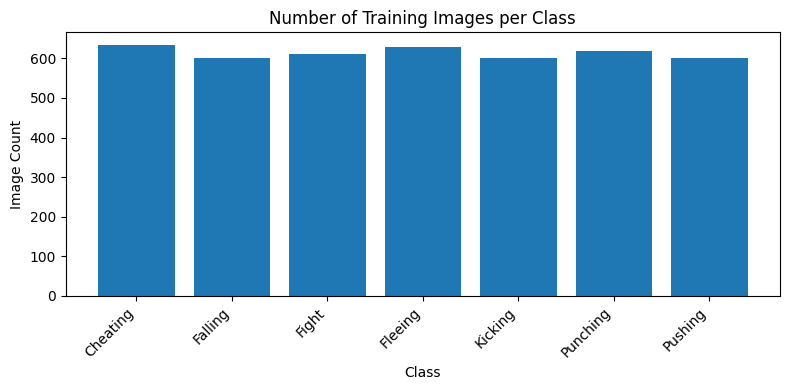

In [ ]:
# compute the number of training images for each class
class_counts = []

for cls in class_names:
    folder = os.path.join(train_dir, cls)
    count = len(os.listdir(folder))
    class_counts.append(count)
    print(f"{cls}: {count}")

# visualize class distribution to check for class imbalance
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts)
plt.xticks(rotation=45, ha="right")
plt.title("number of training images per class")
plt.xlabel("class")
plt.ylabel("image count")
plt.tight_layout()
plt.show()

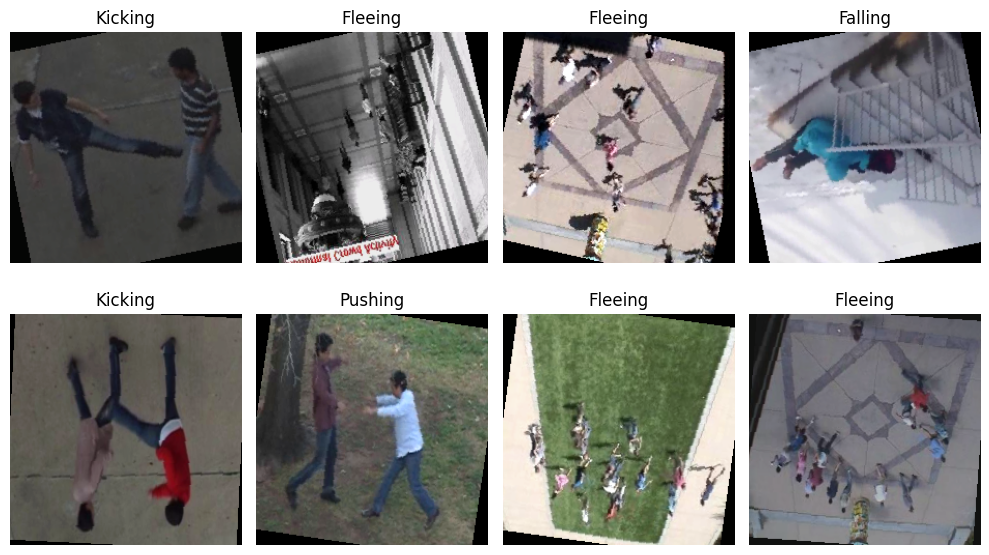

In [ ]:
# visualizing a tensor image after denormalization
def imshow_tensor(img_tensor, title=None):
    # convert tensor from (C, H, W) to (H, W, C)
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    
    # mean and std used during normalization
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    # reverse normalization: img = img * std + mean
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# load one batch of images from the training loader
images, labels = next(iter(train_loader))

# a sample of augmented training images
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow_tensor(images[i], title=class_names[labels[i].item()])
plt.tight_layout()
plt.show()

In [ ]:
# basic convolutional block: conv layer -> batch normalization -> relu activation -> max pooling
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            # convolution with 3×3 kernel and padding to preserve spatial size
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # batch normalization for faster and more stable training
            nn.BatchNorm2d(out_channels),
            # non-linear activation function
            nn.ReLU(inplace=True),
            # downsampling to reduce spatial dimensions by a factor of 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.block(x)

# custom cnn architecture
class AbnormalBehaviourCNN(nn.Module):
    def __init__(self, num_classes):
        super(AbnormalBehaviourCNN, self).__init__()
        
        # feature extraction layers
        self.features = nn.Sequential(
            ConvBlock(3,   32),
            ConvBlock(32,  64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )
        
        # adaptive average pooling to obtain a fixed 1×1 spatial dimension
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),      # regularization to reduce overfitting
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)      # extract spatial features
        x = self.avgpool(x)       # reduce to 1×1 feature map
        x = self.classifier(x)    # classify
        return x

model = AbnormalBehaviourCNN(num_classes=num_classes).to(device)
print(model)

AbnormalBehaviourCNN(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=

## Model Architecture

A custom Convolutional Neural Network (CNN) is designed to perform multi-class classification across seven abnormal behaviour categories. The model is intentionally built from scratch, without using pretrained backbones.

The network consists of four convolutional blocks, each containing:

- a 3×3 convolution layer  
- batch normalization  
- ReLU activation  
- 2×2 max pooling  

These blocks progressively extract hierarchical spatial features while reducing spatial dimensions. Batch normalization stabilizes training, ReLU introduces non-linearity, and max pooling provides translation invariance.

An Adaptive Average Pooling layer reduces the final feature maps to a fixed 1×1 spatial dimension, independent of input size. This allows the model to handle arbitrary image dimensions before reaching the classifier.

The classifier includes:

- a flattening layer  
- a fully connected layer with 128 hidden units  
- ReLU activation  
- dropout (p = 0.5) to prevent overfitting  
- an output layer with num_classes units  

Dropout reduces co-adaptation between neurons and improves model generalization, which is important for relatively small datasets.

In [ ]:
# loss function that computes cross-entropy between predicted probabilities and true labels
criterion = nn.CrossEntropyLoss()

# learning rate for the optimizer
learning_rate = 5e-4

# adam optimizer with weight decay for regularization
optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-4
)

# learning rate scheduler that reduces the learning rate by a factor of 0.5 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=7, 
    gamma=0.5
)

In [ ]:
# training function that performs forward pass, computes loss, backpropagates gradients, and updates model weights
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # iterate over all batches in the dataloader
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # reset accumulated gradients
        
        outputs = model(inputs)          # forward pass
        loss = criterion(outputs, labels) # compute loss
        
        loss.backward()      #  gradients
        optimizer.step()     # update parameters
        
        # batch loss
        running_loss += loss.item() * inputs.size(0)
        
        # number of correct predictions
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    # average loss and accuracy over the entire epoch
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # disable gradient calculations
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)          # forward pass only
            loss = criterion(outputs, labels) # compute loss
            
            running_loss += loss.item() * inputs.size(0)
            
            # compute predictions
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            # labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

In [ ]:
num_epochs = 20

# dictionary to store loss and accuracy values for plotting
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# tracking the best validation accuracy
best_val_acc = 0.0
best_model_state = None

# total training time
start_time = time.time()

# main training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    scheduler.step()
    
    # store training history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    # save the model state with the highest validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    
    print(
        f"Epoch {epoch:02d}/{num_epochs:02d} "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

total_time = time.time() - start_time
print(f"\ntraining finished in {total_time/60:.1f} minutes. best val acc = {best_val_acc:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 01/20 - Train loss: 1.3295, acc: 0.4472 - Val loss: 1.0152, acc: 0.5603
Epoch 02/20 - Train loss: 1.1161, acc: 0.5226 - Val loss: 0.9506, acc: 0.5826
Epoch 03/20 - Train loss: 1.0445, acc: 0.5528 - Val loss: 0.9005, acc: 0.5863
Epoch 04/20 - Train loss: 0.9874, acc: 0.5703 - Val loss: 0.8365, acc: 0.6308
Epoch 05/20 - Train loss: 0.9387, acc: 0.5875 - Val loss: 0.8097, acc: 0.6568
Epoch 06/20 - Train loss: 0.9189, acc: 0.5966 - Val loss: 0.8125, acc: 0.6419
Epoch 07/20 - Train loss: 0.8754, acc: 0.6115 - Val loss: 0.7953, acc: 0.6698
Epoch 08/20 - Train loss: 0.7883, acc: 0.6581 - Val loss: 0.7364, acc: 0.6753
Epoch 09/20 - Train loss: 0.7654, acc: 0.6625 - Val loss: 0.6816, acc: 0.7273
Epoch 10/20 - Train loss: 0.7504, acc: 0.6653 - Val loss: 0.7285, acc: 0.6790
Epoch 11/20 - Train loss: 0.7260, acc: 0.6818 - Val loss: 0.6544, acc: 0.7291
Epoch 12/20 - Train loss: 0.7354, acc: 0.6820 - Val loss: 0.6418, acc: 0.7236
Epoch 13/20 - Train loss: 0.7109, acc: 0.6904 - Val loss: 0.6556

## Training Procedure and Fine-Tuning Strategy

The model is trained using supervised learning across multiple epochs. Each epoch consists of a complete forward and backward pass over the training dataset, followed by an evaluation on the validation dataset.The model uses Cross-Entropy Loss, the standard objective for multi-class classification tasks. It measures how well the predicted probability distribution matches the true class labels. The Adam optimizer is used due to its adaptive learning rate mechanism and stable convergence properties. A small weight decay term acts as L2 regularization, reducing overfitting. A StepLR scheduler decreases the learning rate after a fixed interval of epochs. This allows the model to take larger steps early in training and progressively smaller, more refined steps later. Validation accuracy is monitored each epoch. The model state with the highest validation accuracy is saved and later restored. This behaves similarly to early stopping and ensures that the best-performing version of the model is used during evaluation and deployment.

### Fine-Tuning Phase

After initial training, a fine-tuning stage is performed to further improve model generalization and classification accuracy. Fine-tuning begins with the weights obtained from the initial training stage, meaning the model already has strong learned representations and only requires more precise adjustments. The fine-tuning phase uses a significantly smaller learning rate. This allows the network to make subtle refinements to the learned features without destabilizing previously acquired knowledge. A shorter StepLR schedule is used during this phase, reducing the learning rate more frequently to promote stable convergence.


In [ ]:
# start fine-tuning phase
print("starting fine-tuning...")

# lower learning rate for more precise weight updates
fine_tune_lr = 1e-4

# reinitialize the optimizer with the reduced learning rate
optimizer = optim.Adam(
    model.parameters(),
    lr=fine_tune_lr,
    weight_decay=1e-5
)

# decreases lr every 3 epochs for smoother convergence
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.5
)

fine_tune_epochs = 10

history_ft = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

Starting fine-tuning...


In [ ]:
start_ft = time.time()

# fine-tuning loop
for epoch in range(1, fine_tune_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # evaluate on the validation set
    val_loss, val_acc, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step()

    history_ft["train_loss"].append(train_loss)
    history_ft["train_acc"].append(train_acc)
    history_ft["val_loss"].append(val_loss)
    history_ft["val_acc"].append(val_acc)

    print(
        f"[FT] Epoch {epoch:02d}/{fine_tune_epochs:02d} "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

print("\nfine-tuning completed in %.2f minutes." % (
    (time.time() - start_ft) / 60
))

[FT] Epoch 01/10 - Train loss: 0.5942, acc: 0.7472 - Val loss: 0.5853, acc: 0.7811
[FT] Epoch 02/10 - Train loss: 0.5902, acc: 0.7498 - Val loss: 0.5658, acc: 0.7774
[FT] Epoch 03/10 - Train loss: 0.5796, acc: 0.7565 - Val loss: 0.6100, acc: 0.7384
[FT] Epoch 04/10 - Train loss: 0.5641, acc: 0.7591 - Val loss: 0.5623, acc: 0.7718
[FT] Epoch 05/10 - Train loss: 0.5571, acc: 0.7626 - Val loss: 0.5582, acc: 0.7755
[FT] Epoch 06/10 - Train loss: 0.5591, acc: 0.7551 - Val loss: 0.5531, acc: 0.7495
[FT] Epoch 07/10 - Train loss: 0.5447, acc: 0.7677 - Val loss: 0.5393, acc: 0.7885
[FT] Epoch 08/10 - Train loss: 0.5468, acc: 0.7647 - Val loss: 0.5377, acc: 0.7959
[FT] Epoch 09/10 - Train loss: 0.5430, acc: 0.7740 - Val loss: 0.5305, acc: 0.7922
[FT] Epoch 10/10 - Train loss: 0.5380, acc: 0.7726 - Val loss: 0.5296, acc: 0.7885

Fine-tuning completed in 30.41 minutes.


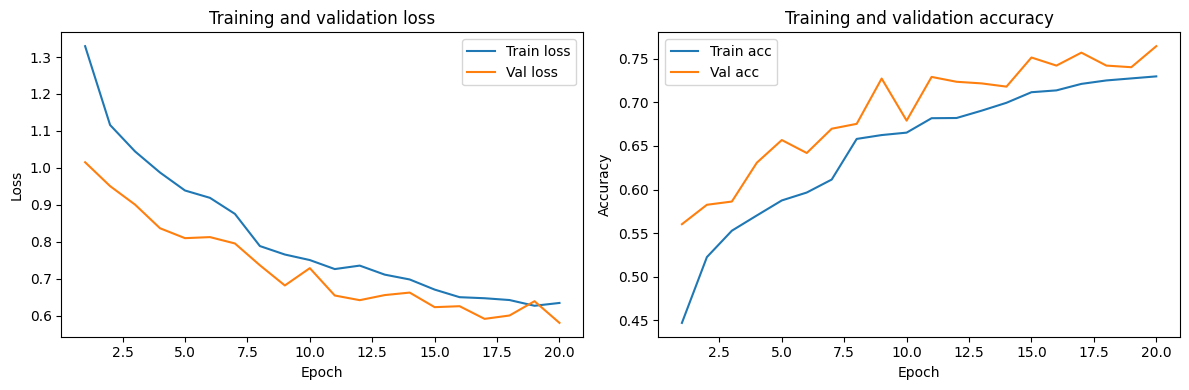

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train loss")
plt.plot(epochs_range, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train acc")
plt.plot(epochs_range, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Test loss: 0.4535
Test accuracy: 0.7937

Classification report:
              precision    recall  f1-score   support

    Cheating       1.00      0.97      0.99        69
     Falling       0.89      0.81      0.85        78
       Fight       0.83      0.92      0.87        74
     Fleeing       1.00      1.00      1.00        77
     Kicking       0.52      0.82      0.63        80
    Punching       0.79      0.24      0.37        79
     Pushing       0.75      0.83      0.79        81

    accuracy                           0.79       538
   macro avg       0.83      0.80      0.78       538
weighted avg       0.82      0.79      0.78       538



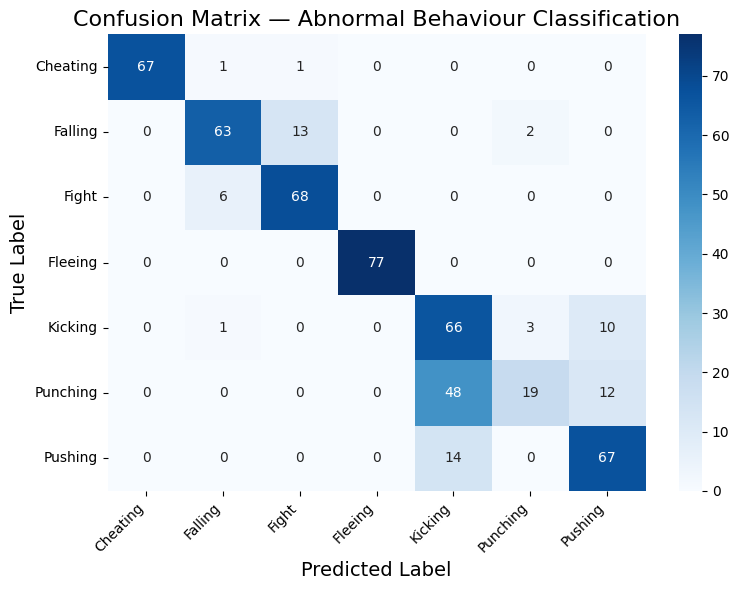

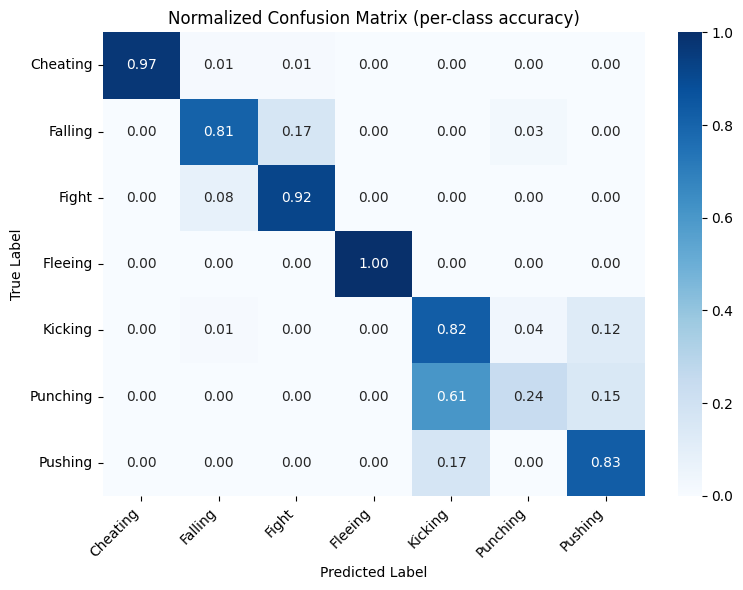

In [26]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.title("Confusion Matrix — Abnormal Behaviour Classification", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Normalized Confusion Matrix (per-class accuracy)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image

inference_transform = val_test_transforms

# function for running inference on a single image path
def predict_image(path, model, device):
    model.eval()
    
    img = Image.open(path).convert("RGB")
    
    img_t = inference_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_t)
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities
        conf, pred_idx = torch.max(probs, 1)   # get predicted class and confidence
    
    predicted_class = class_names[pred_idx.item()]
    confidence = conf.item()
    
    return predicted_class, confidence, img

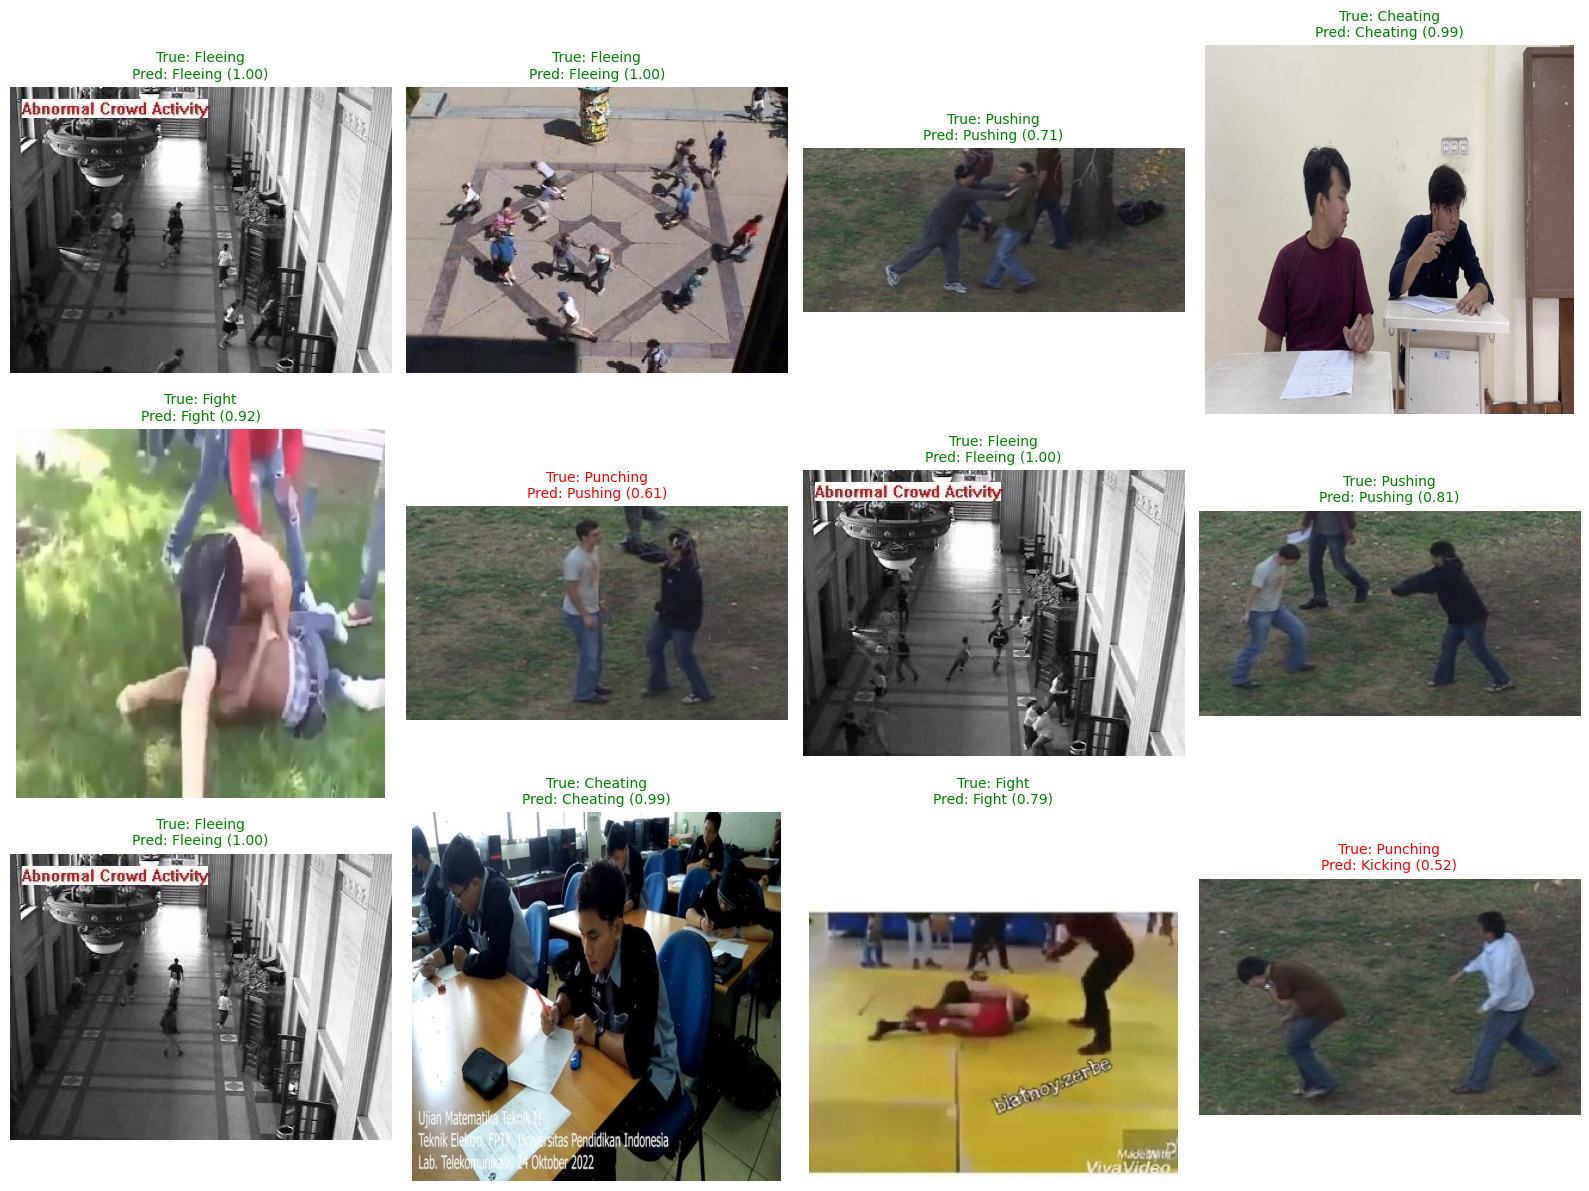

In [28]:
num_images = 12  

test_image_paths = []
test_labels = []

for cls_name in class_names:
    folder = os.path.join(test_dir, cls_name)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            test_image_paths.append(os.path.join(folder, fname))
            test_labels.append(cls_name)

indices = random.sample(range(len(test_image_paths)), num_images)

plt.figure(figsize=(16, 12))

for i, idx in enumerate(indices):
    img_path = test_image_paths[idx]
    true_label = test_labels[idx]
    
    pred_label, confidence, img = predict_image(img_path, model, device)
    
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    
    color = "green" if pred_label == true_label else "red"
    
    plt.title(
        f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", 
        fontsize=10,
        color=color
    )

plt.tight_layout()
plt.show()

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names,
}, "abnormal_behaviour_cnn.pth")